In [170]:
import numpy as np
import pandas as pd
import re
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

In [171]:
from typing import Tuple, Any
from sklearn.experimental import enable_iterative_imputer  # Required to use IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

def basic_summary(data: pd.DataFrame) -> pd.DataFrame:
    """
    basic_summary
    --------------------------------

    Returns basic summary stats for all variables 

    Data    : Pandas dataframe
    
    Returns :
        Pandas dataframe with summary
    """
    columns = data.columns

    stats = pd.DataFrame(index=columns)
    stats['dtype'] =  data[columns].dtypes
    stats['missing_values'] = data[columns].isna().sum()
    stats['missing_values %'] = round (data[columns].isna().sum() / len (data) * 100, 2)
    stats['unique_values'] = data[columns].nunique()

    return stats


def detailed_descriptive_categorical(data: pd.DataFrame) -> pd.DataFrame:
    """
    detailed_descriptive_categorical
    --------------------------------

    Returns useful summary stats for categorical variables 

    Data    : Pandas dataframe
    
    Returns :
        Pandas dataframe with summary
    """
    columns = data.select_dtypes(exclude=[
                                 'int8', 'int16', 'int32', 'int64', 'Int64', 'float16', 'float32', 'float64']).columns
    stats = pd.DataFrame(index=columns)
    stats['missing_values'] = round (data[columns].isna().sum() / len (data) * 100, 2)

    stats['unique_values'] = data[columns].nunique()
    stats['most_frequent'] = data[columns].mode().iloc[0]
    stats['frequency'] = data[columns].apply(
        lambda x: x.value_counts().iloc[0])
    stats['top_5_frequent'] = data[columns].apply(
        lambda x: x.value_counts().head(5).to_dict())
    return stats


def detailed_descriptive_numerical(data: pd.DataFrame) -> pd.DataFrame:
    """
    detailed_descriptive_numerical
    --------------------------------

    Returns useful summary stats for numerical variables 

    Data    : Pandas dataframe
    
    Returns :
        Pandas dataframe with summary
    """

    columns = data.select_dtypes(include=[
                                 'int8', 'int16', 'int32', 'int64', 'Int64', 'float16', 'float32', 'float64']).columns
    # columns = sorted(columns)
    stats = data[columns].describe().round(2).T
    stats['missing_values'] = round (data[columns].isna().sum() / len (data) * 100, 2)
    stats['skew'] = data[columns].skew()
    stats['kurtosis'] = data[columns].kurtosis()
    stats['mode'] = data[columns].mode().iloc[0]
    return stats

def detailed_summary(data: pd.DataFrame, display_top_n=3) -> pd.DataFrame:
    """
    Provides detailed summary for both categorical and numerical variables.

    Data    : Pandas dataframe
    display_top_n : Number of top frequent values to display for categorical variables.
    
    Returns :
        Pandas dataframe with descriptive summary for both categorical and numerical columns.
    """
    # Separate numerical and categorical columns
    categorical_columns = data.select_dtypes(exclude=['int64', 'float64']).columns
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    
    # Summary for numerical columns
    numerical_summary = data[numerical_columns].describe().T
    numerical_summary['missing_values %'] = round(data[numerical_columns].isna().sum() / len(data) * 100, 2)
    numerical_summary['skew'] = data[numerical_columns].skew()
    numerical_summary['kurtosis'] = data[numerical_columns].kurtosis()

    # Summary for categorical columns
    categorical_summary = pd.DataFrame(index=categorical_columns)
    categorical_summary['missing_values %'] = round(data[categorical_columns].isna().sum() / len(data) * 100, 2)
    categorical_summary['unique_values'] = data[categorical_columns].nunique()
    categorical_summary['most_frequent'] = data[categorical_columns].mode().iloc[0]
    categorical_summary['frequency'] = data[categorical_columns].apply(lambda x: x.value_counts().iloc[0])
    categorical_summary['top_n_frequent'] = data[categorical_columns].apply(
        lambda x: dict(x.value_counts().head(display_top_n))
    )

    # Combine both summaries
    combined_summary = pd.concat([numerical_summary, categorical_summary], axis=0)
    
    return combined_summary


def handle_missing_values(data: pd.DataFrame, strategy="mean", impute_categorical=False, knn_neighbors=5) -> Tuple[Any, pd.DataFrame]:
    """
    Handles missing values in the dataframe based on the provided strategy.
    
    strategy : str, default "mean"
        Imputation strategy for numerical columns:
        - "mean": replaces missing values with mean
        - "median": replaces missing values with median
        - "most_frequent": replaces missing values with the most frequent value
        - "knn": uses KNN imputer
        - "iterative": uses Iterative imputer (more advanced)
    
    impute_categorical : bool, default True
        Whether to impute categorical variables with the most frequent value.
    
    knn_neighbors : int, default 5
        Number of neighbors to use for KNN imputation.
    
    Returns:
        imputer --> useful for imputing test sets or review model parameters.
        DataFrame with missing values handled.
    """
    
    data_cleaned = data.copy()
    
    # Separate numerical and categorical columns
    numerical_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = data_cleaned.select_dtypes(exclude=['float64', 'int64']).columns
    
    if len(numerical_cols) > 0:
        # Handle missing values for numerical columns
        if strategy in ["mean", "median", "most_frequent"]:
            imputer = SimpleImputer(strategy=strategy)
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
        
        elif strategy == "knn":
            imputer = KNNImputer(n_neighbors=knn_neighbors)
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
        
        elif strategy == "iterative":
            imputer = IterativeImputer()
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
    
    # Handle missing values for categorical columns (if applicable)
    if len(categorical_cols) > 0 and impute_categorical:
        imputer = SimpleImputer(strategy="most_frequent")
        data_cleaned[categorical_cols] = imputer.fit_transform(data_cleaned[categorical_cols])
    
    return imputer, data_cleaned


def cap_outliers_isolation_forest(data: pd.DataFrame, columns: list, contamination: float = 0.01) -> pd.DataFrame:
    """
    cap_outliers_isolation_forest
    -----------------------------

    Caps columns in data using Isolation Forest

    data    : Pandas dataframe
    columns : list of columns

    Returns :
        Capped dataframe
    
    """

    clf = IsolationForest(contamination=contamination, random_state=42)

    for column in columns:
        data['outlier_if'] = clf.fit_predict(data[[column]])

        non_outliers = data[data['outlier_if'] == 1][column]
        lower_bound = non_outliers.min()
        upper_bound = non_outliers.max()

        data[column] = np.where(data[column] < lower_bound,
                              lower_bound, data[column])
        data[column] = np.where(data[column] > upper_bound,
                              upper_bound, data[column])

        data = data.drop(columns=['outlier_if'])
        print(f'Capped outliers in {column}')

    return data

# Telecom Churn Prediction

# The Plan

#### 1. Data Understanding and Preprocessing
   - Load and inspect the dataset.
   - Handle missing values if any.
   - Encode categorical variables.

#### 2. Exploratory Data Analysis (EDA)
   - Visualize the data distribution.
   - Understand feature relationships.
   - Identify trends and correlations.
   - Perform hypothesis testing if needed.

#### 3. Feature Engineering
   - Create new features or transform existing ones.
   - Handle multicollinearity (if applicable).
   - Perform PCA for dimensionality reduction (after scaling/normalization if needed).

#### 4. Feature Scaling/Normalization
   - Apply scaling or normalization depending on the requirements of the models.

#### 5. Principal Component Analysis (PCA)
   - Apply PCA to reduce the dimensionality of the dataset.

#### 6. Handle Class Imbalance (if applicable)
   - If class imbalance exists, apply resampling techniques (over-sampling, under-sampling, or SMOTE).

#### 7. Model Selection
   - Split the data into training and testing sets.
   - Choose multiple models to evaluate:
     - Logistic Regression
     - Decision Trees
     - Random Forest
     - SVM
     - Naive Bayes
     - Boosting methods (XGBoost, LightGBM)
   - Build pipelines for each model.

#### 8. Model Evaluation and Tuning
   - Evaluate model performance on the validation set using metrics such as accuracy, precision, recall, F1-score, ROC-AUC.
   - Use cross-validation to reduce overfitting.
   - Perform hyperparameter tuning (GridSearchCV, RandomSearchCV).

#### 9. Ensemble Modeling (optional)
   - Combine multiple models to improve overall performance using techniques like voting classifiers or stacking.

#### 10. Final Model Evaluation
   - Evaluate the best model on the test set.
   - Calculate final performance metrics.

#### 11. Submission Preparation
   - Prepare predictions on the test dataset.
   - Generate submission file for Kaggle competition.


# 1. **Data Understanding and Preprocessing:**
   - Load and inspect the dataset.
   - Handle missing values if any.
   - Encode categorical variables.
   - Feature scaling and normalization (if necessary).
   - Check for class imbalance and decide on sampling strategies (over-sampling, under-sampling, SMOTE, etc.).


### Load and inspect the dataset.


In [172]:
data = pd.read_csv("https://raw.githubusercontent.com/mohiteamit/upGrad-TelecomChurnCaseStudy/refs/heads/main/data/train.csv")
unseen = pd.read_csv("https://github.com/mohiteamit/upGrad-TelecomChurnCaseStudy/raw/refs/heads/main/data/test.csv")

`Dictionary.csv`

|Acronyms|Description|
|---|---|
|CIRCLE_ID|Telecom circle area to which the customer belongs to|
|LOC|Local calls  within same telecom circle|
|STD|STD calls  outside the calling circle|
|IC|Incoming calls|
|OG|Outgoing calls|
|T2T|Operator T to T ie within same operator mobile to mobile|
|T2M    |Operator T to other operator mobile|
|T2O    |Operator T to other operator fixed line|
|T2F    |Operator T to fixed lines of T|
|T2C    |Operator T to its own call center|
|ARPU    |Average revenue per user|
|MOU    |Minutes of usage  voice calls|
|AON    |Age on network  number of days the customer is using the operator T network|
|ONNET   |All kind of calls within the same operator network|
|OFFNET    |All kind of calls outside the operator T network|
|ROAM|Indicates that customer is in roaming zone during the call|
|SPL   |Special calls|
|ISD    |ISD calls|
|RECH    |Recharge|
|NUM    |Number|
|AMT    |Amount in local currency|
|MAX    |Maximum|
|DATA    |Mobile internet|
|3G    |G network|
|AV    |Average|
|VOL    |Mobile internet usage volume in MB|
|2G    |G network|
|PCK    |Prepaid service schemes called  PACKS|
|NIGHT    |Scheme to use during specific night hours only|
|MONTHLY    |Service schemes with validity equivalent to a month|
|SACHET   |Service schemes with validity smaller than a month|
|*.6    |KPI for the month of June|
|*.7    |KPI for the month of July|
|*.8    |KPI for the month of August|
|FB_USER|Service scheme to avail services of Facebook and similar social networking sites|
|VBC    |Volume based cost  when no specific scheme is not purchased and paid as per usage|

In [ ]:
data.head(n=10)

### Handle missing values if any.

`Before moving on to handle missing values lets seperate predictors and target variable. This will helps us align train and test and apply missing value strategy to test dataset as well`

In [ ]:
X = data.drop(columns=['churn_probability'], axis=1)
y = data['churn_probability']
X.shape, y.shape

In [ ]:
X.columns.equals(unseen.columns) # Checking X and unseen test data as same columns

In [ ]:
detailed_descriptive_categorical(data=X)

**Handling for few date time variables in data**

`The following variables, including the date_of_last_rech_data_*, have missing values. However, these missing values are not random but are indicators of customer behavior, highlighting that the user did not recharge during that month. This information will be leveraged during feature engineering, as the absence of recharge activity is a key signal for predicting churn.`


| Column                  | Missing Values (%) | Unique Values | Most Frequent Value | Frequency | Top 5 Frequent                                          |
|-------------------------|--------------------|---------------|---------------------|-----------|---------------------------------------------------------|
| date_of_last_rech_6      | 1.57               | 30            | 6/30/2014           | 11880     | {'6/30/2014': 11880, '6/29/2014': 9049, '6/27/2014': ...} |
| date_of_last_rech_7      | 1.76               | 31            | 7/31/2014           | 12206     | {'7/31/2014': 12206, '7/30/2014': 9716, '7/25/2014': ...} |
| date_of_last_rech_8      | 3.52               | 31            | 8/31/2014           | 10324     | {'8/31/2014': 10324, '8/30/2014': 8187, '8/29/2014': ...} |
| date_of_last_rech_data_6 | 74.90              | 30            | 6/30/2014           | 1317      | {'6/30/2014': 1317, '6/29/2014': 1148, '6/28/2014': ...} |
| date_of_last_rech_data_7 | 74.48              | 31            | 7/31/2014           | 1282      | {'7/31/2014': 1282, '7/29/2014': 1200, '7/30/2014': ...} |
| date_of_last_rech_data_8 | 73.69              | 31            | 8/31/2014           | 1388      | {'8/31/2014': 1388, '8/30/2014': 1306, '8/29/2014': ...} |


In [177]:
# Fix data type for datetime columns

X['date_of_last_rech_6'] = pd.to_datetime(X['date_of_last_rech_6'])
X['date_of_last_rech_7'] = pd.to_datetime(X['date_of_last_rech_7'])
X['date_of_last_rech_8'] = pd.to_datetime(data['date_of_last_rech_8'])
X['date_of_last_rech_data_6'] = pd.to_datetime(X['date_of_last_rech_data_6'])
X['date_of_last_rech_data_7'] = pd.to_datetime(X['date_of_last_rech_data_7'])
X['date_of_last_rech_data_8'] = pd.to_datetime(X['date_of_last_rech_data_8'])

# Rest of the columns are in right format

In [178]:
columns_to_keep = [] # Will always hold columns to keep for next step.

In [ ]:
columns_to_keep = []
for c in X.columns:
    m =  X[c].isna().sum() / len (X) * 100
    if m < 70:
        columns_to_keep.append(c)

columns_to_keep.append('date_of_last_rech_data_6')
columns_to_keep.append('date_of_last_rech_data_7')
columns_to_keep.append('date_of_last_rech_data_8')


len(columns_to_keep)

In [180]:
X = X[columns_to_keep]
unseen = unseen[[v for v in columns_to_keep if not v == 'churn_probability']] # Ensuring unseen is updated as well

In [181]:
# basic_summary(data=data).sort_values(by='unique_values', ascending=True)

In [ ]:
# Let's remove all variables with 1 unique value
basicsummary = basic_summary(data=X)
columns_to_keep = basicsummary[basicsummary['unique_values'] > 1].index
len(columns_to_keep)

In [183]:
X = X[columns_to_keep]
unseen = unseen[[v for v in columns_to_keep if not v == 'churn_probability']] # Ensuring unseen is updated as well

In [ ]:
basic_summary(data=X).sort_values(by='missing_values %', ascending=False)
# basic_summary(data=X).sort_index()

In [185]:
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(exclude=['float64', 'int64']).columns 

In [ ]:
detailed_descriptive_categorical(data=X)

`Reminder` we are not going to impute data for following variables

| Column                  | Missing Values (%) | Unique Values | Most Frequent Value | Frequency | Top 5 Frequent                                          |
|-------------------------|--------------------|---------------|---------------------|-----------|---------------------------------------------------------|
| date_of_last_rech_6      | 1.57               | 30            | 6/30/2014           | 11880     | {'6/30/2014': 11880, '6/29/2014': 9049, '6/27/2014': ...} |
| date_of_last_rech_7      | 1.76               | 31            | 7/31/2014           | 12206     | {'7/31/2014': 12206, '7/30/2014': 9716, '7/25/2014': ...} |
| date_of_last_rech_8      | 3.52               | 31            | 8/31/2014           | 10324     | {'8/31/2014': 10324, '8/30/2014': 8187, '8/29/2014': ...} |
| date_of_last_rech_data_6 | 74.90              | 30            | 6/30/2014           | 1317      | {'6/30/2014': 1317, '6/29/2014': 1148, '6/28/2014': ...} |
| date_of_last_rech_data_7 | 74.48              | 31            | 7/31/2014           | 1282      | {'7/31/2014': 1282, '7/29/2014': 1200, '7/30/2014': ...} |
| date_of_last_rech_data_8 | 73.69              | 31            | 8/31/2014           | 1388      | {'8/31/2014': 1388, '8/30/2014': 1306, '8/29/2014': ...} |


--------------


If we we had to impute, following is the code

```python
imputer_catgorical, X[categorical_cols] = handle_missing_values(
    data=X[categorical_cols],
    strategy='most_frequent',
    impute_categorical=True                   
)


In [187]:
# Imputing numeric variables in train set
imputer_numerical, X[numerical_cols] = handle_missing_values(
    data=X[numerical_cols],
    strategy='median'                      
)

In [188]:
# Imputing numerical variables in test set
unseen[numerical_cols]  = imputer_numerical.transform(unseen[numerical_cols])

In [ ]:
basic_summary(data=X).sort_values(by='missing_values %', ascending=False).sort_index()

Summary after handling missing values.

| column | dtype | missing_values | missing_values % | unique_values |
| --- | --- | --- | --- | --- |
| aon | float64 | 0 | 0.00 | 3455 |
| arpu_6 | float64 | 0 | 0.00 | 61615 |
| arpu_7 | float64 | 0 | 0.00 | 61425 |
| arpu_8 | float64 | 0 | 0.00 | 60194 |
| aug_vbc_3g | float64 | 0 | 0.00 | 10609 |
| date_of_last_rech_6 | object | 1101 | 1.57 | 30 |
| date_of_last_rech_7 | object | 1234 | 1.76 | 31 |
| date_of_last_rech_8 | object | 2461 | 3.52 | 31 |
| date_of_last_rech_data_6 | object | 52431 | 74.90 | 30 |
| date_of_last_rech_data_7 | object | 52134 | 74.48 | 31 |
| date_of_last_rech_data_8 | object | 51582 | 73.69 | 31 |
| ic_others_6 | float64 | 0 | 0.00 | 1523 |
| ic_others_7 | float64 | 0 | 0.00 | 1658 |
| ic_others_8 | float64 | 0 | 0.00 | 1565 |
| id | float64 | 0 | 0.00 | 69999 |
| isd_ic_mou_6 | float64 | 0 | 0.00 | 4421 |
| isd_ic_mou_7 | float64 | 0 | 0.00 | 4640 |
| isd_ic_mou_8 | float64 | 0 | 0.00 | 4694 |
| isd_og_mou_6 | float64 | 0 | 0.00 | 1103 |
| isd_og_mou_7 | float64 | 0 | 0.00 | 1084 |
| isd_og_mou_8 | float64 | 0 | 0.00 | 1008 |
| jul_vbc_3g | float64 | 0 | 0.00 | 10257 |
| jun_vbc_3g | float64 | 0 | 0.00 | 9617 |
| last_day_rch_amt_6 | float64 | 0 | 0.00 | 179 |
| last_day_rch_amt_7 | float64 | 0 | 0.00 | 166 |
| last_day_rch_amt_8 | float64 | 0 | 0.00 | 191 |
| loc_ic_mou_6 | float64 | 0 | 0.00 | 24442 |
| loc_ic_mou_7 | float64 | 0 | 0.00 | 24258 |
| loc_ic_mou_8 | float64 | 0 | 0.00 | 24182 |
| loc_ic_t2f_mou_6 | float64 | 0 | 0.00 | 6200 |
| loc_ic_t2f_mou_7 | float64 | 0 | 0.00 | 6287 |
| loc_ic_t2f_mou_8 | float64 | 0 | 0.00 | 6092 |
| loc_ic_t2m_mou_6 | float64 | 0 | 0.00 | 19034 |
| loc_ic_t2m_mou_7 | float64 | 0 | 0.00 | 18945 |
| loc_ic_t2m_mou_8 | float64 | 0 | 0.00 | 19022 |
| loc_ic_t2t_mou_6 | float64 | 0 | 0.00 | 11637 |
| loc_ic_t2t_mou_7 | float64 | 0 | 0.00 | 11595 |
| loc_ic_t2t_mou_8 | float64 | 0 | 0.00 | 11446 |
| loc_og_mou_6 | float64 | 0 | 0.00 | 22309 |
| loc_og_mou_7 | float64 | 0 | 0.00 | 22012 |
| loc_og_mou_8 | float64 | 0 | 0.00 | 21951 |
| loc_og_t2c_mou_6 | float64 | 0 | 0.00 | 1945 |
| loc_og_t2c_mou_7 | float64 | 0 | 0.00 | 2103 |
| loc_og_t2c_mou_8 | float64 | 0 | 0.00 | 2204 |
| loc_og_t2f_mou_6 | float64 | 0 | 0.00 | 3376 |
| loc_og_t2f_mou_7 | float64 | 0 | 0.00 | 3365 |
| loc_og_t2f_mou_8 | float64 | 0 | 0.00 | 3311 |
| loc_og_t2m_mou_6 | float64 | 0 | 0.00 | 17848 |
| loc_og_t2m_mou_7 | float64 | 0 | 0.00 | 17642 |
| loc_og_t2m_mou_8 | float64 | 0 | 0.00 | 17617 |
| loc_og_t2t_mou_6 | float64 | 0 | 0.00 | 11491 |
| loc_og_t2t_mou_7 | float64 | 0 | 0.00 | 11359 |
| loc_og_t2t_mou_8 | float64 | 0 | 0.00 | 11296 |
| max_rech_amt_6 | float64 | 0 | 0.00 | 190 |
| max_rech_amt_7 | float64 | 0 | 0.00 | 178 |
| max_rech_amt_8 | float64 | 0 | 0.00 | 202 |
| monthly_2g_6 | float64 | 0 | 0.00 | 5 |
| monthly_2g_7 | float64 | 0 | 0.00 | 6 |
| monthly_2g_8 | float64 | 0 | 0.00 | 6 |
| monthly_3g_6 | float64 | 0 | 0.00 | 10 |
| monthly_3g_7 | float64 | 0 | 0.00 | 13 |
| monthly_3g_8 | float64 | 0 | 0.00 | 12 |
| offnet_mou_6 | float64 | 0 | 0.00 | 26254 |
| offnet_mou_7 | float64 | 0 | 0.00 | 26140 |
| offnet_mou_8 | float64 | 0 | 0.00 | 25996 |
| og_others_6 | float64 | 0 | 0.00 | 914 |
| og_others_7 | float64 | 0 | 0.00 | 148 |
| og_others_8 | float64 | 0 | 0.00 | 179 |
| onnet_mou_6 | float64 | 0 | 0.00 | 20057 |
| onnet_mou_7 | float64 | 0 | 0.00 | 20076 |
| onnet_mou_8 | float64 | 0 | 0.00 | 19726 |
| roam_ic_mou_6 | float64 | 0 | 0.00 | 5306 |
| roam_ic_mou_7 | float64 | 0 | 0.00 | 4240 |
| roam_ic_mou_8 | float64 | 0 | 0.00 | 4252 |
| roam_og_mou_6 | float64 | 0 | 0.00 | 6568 |
| roam_og_mou_7 | float64 | 0 | 0.00 | 5305 |
| roam_og_mou_8 | float64 | 0 | 0.00 | 5215 |
| sachet_2g_6 | float64 | 0 | 0.00 | 30 |
| sachet_2g_7 | float64 | 0 | 0.00 | 33 |
| sachet_2g_8 | float64 | 0 | 0.00 | 32 |
| sachet_3g_6 | float64 | 0 | 0.00 | 23 |
| sachet_3g_7 | float64 | 0 | 0.00 | 26 |
| sachet_3g_8 | float64 | 0 | 0.00 | 28 |
| spl_ic_mou_6 | float64 | 0 | 0.00 | 78 |
| spl_ic_mou_7 | float64 | 0 | 0.00 | 103 |
| spl_ic_mou_8 | float64 | 0 | 0.00 | 95 |
| spl_og_mou_6 | float64 | 0 | 0.00 | 3503 |
| spl_og_mou_7 | float64 | 0 | 0.00 | 3827 |
| spl_og_mou_8 | float64 | 0 | 0.00 | 3848 |
| std_ic_mou_6 | float64 | 0 | 0.00 | 9876 |
| std_ic_mou_7 | float64 | 0 | 0.00 | 10112 |
| std_ic_mou_8 | float64 | 0 | 0.00 | 9939 |
| std_ic_t2f_mou_6 | float64 | 0 | 0.00 | 2624 |
| std_ic_t2f_mou_7 | float64 | 0 | 0.00 | 2695 |
| std_ic_t2f_mou_8 | float64 | 0 | 0.00 | 2583 |
| std_ic_t2m_mou_6 | float64 | 0 | 0.00 | 7931 |
| std_ic_t2m_mou_7 | float64 | 0 | 0.00 | 8033 |
| std_ic_t2m_mou_8 | float64 | 0 | 0.00 | 7906 |
| std_ic_t2t_mou_6 | float64 | 0 | 0.00 | 5323 |
| std_ic_t2t_mou_7 | float64 | 0 | 0.00 | 5479 |
| std_ic_t2t_mou_8 | float64 | 0 | 0.00 | 5367 |
| std_og_mou_6 | float64 | 0 | 0.00 | 21837 |
| std_og_mou_7 | float64 | 0 | 0.00 | 22088 |
| std_og_mou_8 | float64 | 0 | 0.00 | 21746 |
| std_og_t2f_mou_6 | float64 | 0 | 0.00 | 2074 |
| std_og_t2f_mou_7 | float64 | 0 | 0.00 | 1991 |
| std_og_t2f_mou_8 | float64 | 0 | 0.00 | 1945 |
| std_og_t2m_mou_6 | float64 | 0 | 0.00 | 16059 |
| std_og_t2m_mou_7 | float64 | 0 | 0.00 | 16234 |
| std_og_t2m_mou_8 | float64 | 0 | 0.00 | 15968 |
| std_og_t2t_mou_6 | float64 | 0 | 0.00 | 14554 |
| std_og_t2t_mou_7 | float64 | 0 | 0.00 | 14745 |
| std_og_t2t_mou_8 | float64 | 0 | 0.00 | 14483 |
| total_ic_mou_6 | float64 | 0 | 0.00 | 27432 |
| total_ic_mou_7 | float64 | 0 | 0.00 | 27418 |
| total_ic_mou_8 | float64 | 0 | 0.00 | 27318 |
| total_og_mou_6 | float64 | 0 | 0.00 | 33135 |
| total_og_mou_7 | float64 | 0 | 0.00 | 33195 |
| total_og_mou_8 | float64 | 0 | 0.00 | 32897 |
| total_rech_amt_6 | float64 | 0 | 0.00 | 2108 |
| total_rech_amt_7 | float64 | 0 | 0.00 | 2147 |
| total_rech_amt_8 | float64 | 0 | 0.00 | 2149 |
| total_rech_num_6 | float64 | 0 | 0.00 | 94 |
| total_rech_num_7 | float64 | 0 | 0.00 | 96 |
| total_rech_num_8 | float64 | 0 | 0.00 | 92 |
| vol_2g_mb_6 | float64 | 0 | 0.00 | 11494 |
| vol_2g_mb_7 | float64 | 0 | 0.00 | 11443 |
| vol_2g_mb_8 | float64 | 0 | 0.00 | 11359 |
| vol_3g_mb_6 | float64 | 0 | 0.00 | 9768 |
| vol_3g_mb_7 | float64 | 0 | 0.00 | 10296 |
| vol_3g_mb_8 | float64 | 0 | 0.00 | 10663 |


### Encode categorical variables

No categorical variables to encode

In [ ]:
X.shape, y.shape, unseen.shape

In [191]:
# Build data back to what it should have been
data = pd.concat([X, y], join='inner', axis=1)

In [ ]:
data.head(n=5).T

# 2. Exploratory Data Analysis (EDA)
   - Visualize the data distribution.
   - Understand feature relationships.
   - Identify trends and correlations.
   - Perform hypothesis testing if needed.

In [ ]:
plt.figure(figsize=(10, 6))
churn_counts = data['churn_probability'].value_counts().sort_index()
sns.barplot(x=churn_counts.index, y=churn_counts.values, edgecolor='black', alpha=0.7)

# Add exact count and percentage to the chart for 0 and 1
count_0, count_1 = churn_counts[0], churn_counts[1]
percentage_0 = (count_0 / len(data)) * 100
percentage_1 = (count_1 / len(data)) * 100

plt.text(0, count_0, f'{int(count_0)} ({percentage_0:.2f}%)', ha='center', va='bottom')
plt.text(1, count_1, f'{int(count_1)} ({percentage_1:.2f}%)', ha='center', va='bottom')

plt.title('Distribution of Churn Probability')
plt.xlabel('Churn Probability')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['0', '1'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

`We are not going to review each variable one by one as number of variables is large`


### Correlation 

We will look at correalation of each variable pair and see if some what story it tells us

In [ ]:
# Create a temporary copy of the data without the 'id' column
data_temp = data.drop(columns=['id'])

# Divide the data by churn probability
data_churn_0 = data_temp[data_temp['churn_probability'] == 0]
data_churn_1 = data_temp[data_temp['churn_probability'] == 1]

# Calculate the correlation matrix for each group and the overall correlation matrix
correlation_matrix_total = data_temp.corr().round(4)
correlation_matrix_0 = data_churn_0.corr().round(4)
correlation_matrix_1 = data_churn_1.corr().round(4)

# Get the upper triangle of the correlation matrix for each group and the total
upper_triangle_total = correlation_matrix_total.where(
    np.triu(np.ones(correlation_matrix_total.shape), k=1).astype(bool)
)
upper_triangle_0 = correlation_matrix_0.where(
    np.triu(np.ones(correlation_matrix_0.shape), k=1).astype(bool)
)
upper_triangle_1 = correlation_matrix_1.where(
    np.triu(np.ones(correlation_matrix_1.shape), k=1).astype(bool)
)

# Unstack the matrices and drop NaN values
correlation_pairs_total = upper_triangle_total.unstack().dropna()
correlation_pairs_0 = upper_triangle_0.unstack().dropna()
correlation_pairs_1 = upper_triangle_1.unstack().dropna()

# Convert the correlation pairs to dataframes
correlation_pairs_df_total = correlation_pairs_total.reset_index()
correlation_pairs_df_total.columns = ['Variable 1', 'Variable 2', 'Correlation (Total)']

correlation_pairs_df_0 = correlation_pairs_0.reset_index()
correlation_pairs_df_0.columns = ['Variable 1', 'Variable 2', 'Correlation (Churn=0)']

correlation_pairs_df_1 = correlation_pairs_1.reset_index()
correlation_pairs_df_1.columns = ['Variable 1', 'Variable 2', 'Correlation (Churn=1)']

# Merge the correlation dataframes
correlation_pairs_df = correlation_pairs_df_total.merge(correlation_pairs_df_0, on=['Variable 1', 'Variable 2'], how='left')
correlation_pairs_df = correlation_pairs_df.merge(correlation_pairs_df_1, on=['Variable 1', 'Variable 2'], how='left')
correlation_pairs_df['Correlation (Total) (ABS)'] = correlation_pairs_df['Correlation (Total)'].abs()
correlation_pairs_df['Correlation (Churn=0) (ABS)'] = correlation_pairs_df['Correlation (Churn=0)'].abs()
correlation_pairs_df['Correlation (Churn=1) (ABS)'] = correlation_pairs_df['Correlation (Churn=1)'].abs()

# Save the merged correlation pairs to a CSV file
correlation_pairs_df.to_csv('correlation_pairs_combined.csv', index=False)

print("Combined correlation pairs saved to 'correlation_pairs_combined.csv'")

### Review of correlation scores


1. Revenue v/s recharge
- Correlation of revenue with respective month indicate recharge for the month is directly reflected towards revenue for the month
- Low correlation between revenue and recharge amounged churned users may also indicate users tend to spend less as they churn
- Number of recharge follow similat trend

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_rech_amt_8 | arpu_8 | 0.9583 | 0.9582 | 0.9405 |
| total_rech_amt_7 | arpu_7 | 0.9553 | 0.9560 | 0.9461 |
| total_rech_amt_6 | arpu_6 | 0.9528 | 0.9536 | 0.9477 |
| total_rech_amt_7 | arpu_8 | 0.7788 | 0.8003 | 0.5374 |
| total_rech_amt_8 | arpu_7 | 0.7672 | 0.7913 | 0.4927 |
| total_rech_amt_6 | arpu_7 | 0.7511 | 0.7880 | 0.4823 |
| total_rech_amt_7 | arpu_6 | 0.7260 | 0.7705 | 0.4173 |
| total_rech_amt_6 | arpu_8 | 0.6390 | 0.6936 | 0.2420 |
| total_rech_amt_8 | arpu_6 | 0.6268 | 0.6871 | 0.1989 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_rech_num_8 | total_rech_num_7 | 0.7239 | 0.7418 | 0.5518 |
| total_rech_num_7 | total_rech_num_6 | 0.6703 | 0.7002 | 0.4854 |
| total_rech_num_8 | total_rech_num_6 | 0.5167 | 0.5649 | 0.2084 |


2. Outgoin ISD calls

- Users likey start making less call as the are about to churn as shown in reduced correlation in churn v/s previous month 
- User which do not churn continue to likely make similar amount of calls

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_og_mou_8 | total_og_mou_7 | 0.7693 | 0.7928 | 0.5873 |
| total_og_mou_7 | total_og_mou_6 | 0.7245 | 0.7464 | 0.6102 |
| total_og_mou_8 | total_og_mou_6 | 0.5659 | 0.6157 | 0.2840 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| isd_og_mou_8 | isd_og_mou_7 | 0.9470 | 0.9582 | 0.5492 |
| isd_og_mou_7 | isd_og_mou_6 | 0.9340 | 0.9588 | 0.4444 |
| isd_og_mou_8 | isd_og_mou_6 | 0.9241 | 0.9526 | 0.2640 |

3. Churn v/s age of network
- Very low negative correlation indicating as age increases churn probability reduces but is not guaranteed
- This correlation is likely affected by class imbalance as well and I would other expect bit higher negative correlation

| Variable 1 | Variable 2 | Correlation (Total) |
| --- | --- | --- |
| churn_probability | aon | -0.1352 |


4. Within operator network and outside operator network
- Similar trend of low correlation between months which are further apart, indicating call volume goes down as people churn.

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| onnet_mou_8 | onnet_mou_7 | 0.7875 | 0.8081 | 0.6340 |
| onnet_mou_7 | onnet_mou_6 | 0.7339 | 0.7510 | 0.6528 |
| onnet_mou_8 | onnet_mou_6 | 0.5978 | 0.6421 | 0.3567 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| offnet_mou_8 | offnet_mou_7 | 0.7557 | 0.7796 | 0.5331 |
| offnet_mou_7 | offnet_mou_6 | 0.7405 | 0.7597 | 0.6321 |
| offnet_mou_8 | offnet_mou_6 | 0.5734 | 0.6178 | 0.2713 |



`Based on above we may explore creating features which capture change usages` 

In [161]:
numerical_cols = X.select_dtypes(include=[
                                 'int8', 'int16', 'int32', 'int64', 'Int64', 'float16', 'float32', 'float64']).columns

In [199]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [212]:
# Create a copy of the original data
modified_data = data.copy()

# Create a new feature to capture usage change between arpu_6, arpu_7, arpu_8
# We are interested in the latest change between months (either 6 to 7, 7 to 8, or 6 to 8)

def calculate_arpu_change(row):
    if not pd.isna(row['arpu_8']) and not pd.isna(row['arpu_7']):
        return (row['arpu_8'] - row['arpu_7']) / (np.abs(row['arpu_7']) + 1e-5)
    elif not pd.isna(row['arpu_7']) and not pd.isna(row['arpu_6']):
        return (row['arpu_7'] - row['arpu_6']) / (np.abs(row['arpu_6']) + 1e-5)
    elif not pd.isna(row['arpu_8']) and not pd.isna(row['arpu_6']):
        return (row['arpu_8'] - row['arpu_6']) / (np.abs(row['arpu_6']) + 1e-5)
    else:
        return 0

def calculate_recharge_change(row):
    if not pd.isna(row['total_rech_amt_8']) and not pd.isna(row['total_rech_amt_7']):
        return (row['total_rech_amt_8'] - row['total_rech_amt_7']) / (np.abs(row['total_rech_amt_7']) + 1e-5)
    elif not pd.isna(row['total_rech_amt_7']) and not pd.isna(row['total_rech_amt_6']):
        return (row['total_rech_amt_7'] - row['total_rech_amt_6']) / (np.abs(row['total_rech_amt_6']) + 1e-5)
    elif not pd.isna(row['total_rech_amt_8']) and not pd.isna(row['total_rech_amt_6']):
        return (row['total_rech_amt_8'] - row['total_rech_amt_6']) / (np.abs(row['total_rech_amt_6']) + 1e-5)
    else:
        return 0
    
# Apply the function to create a new feature 'latest_arpu_change'
modified_data['latest_arpu_change'] = modified_data.apply(calculate_arpu_change, axis=1)
modified_data['latest_rech_amt_change'] = modified_data.apply(calculate_recharge_change, axis=1)

# Prepare the features for scaling
features_in_use = ['latest_arpu_change', 'latest_rech_amt_change', 'aon']
scaler = StandardScaler()
modified_data[features_in_use] = scaler.fit_transform(modified_data[features_in_use])

# Prepare data for modeling
X = modified_data[features_in_use]
y = modified_data['churn_probability']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Prepare unseen data aswell
unseen_copy = unseen.copy()
unseen_copy['latest_arpu_change'] = unseen_copy.apply(calculate_arpu_change, axis=1)
unseen_copy['latest_rech_amt_change'] = unseen_copy.apply(calculate_recharge_change, axis=1)
unseen_copy[features_in_use] = scaler.transform(unseen_copy[features_in_use])


Accuracy of the model using 'latest_arpu_change' feature: 0.91
ROC AUC Score: 0.83


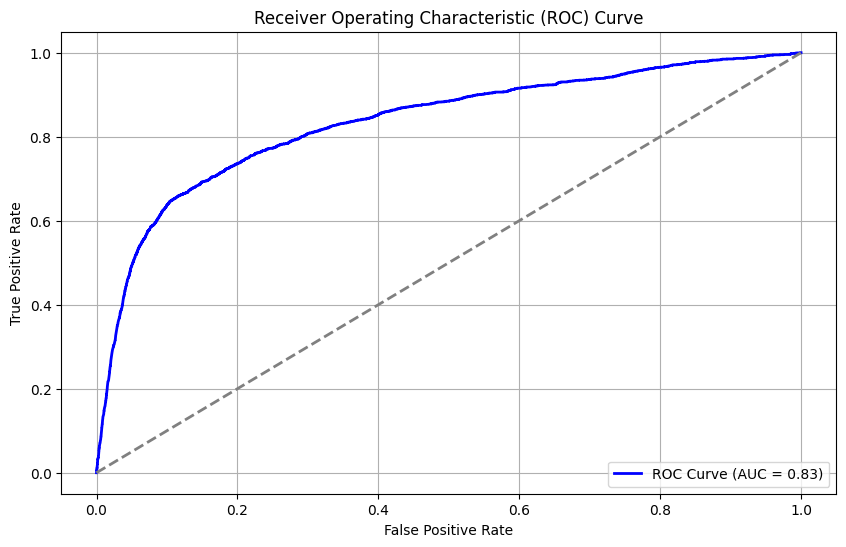

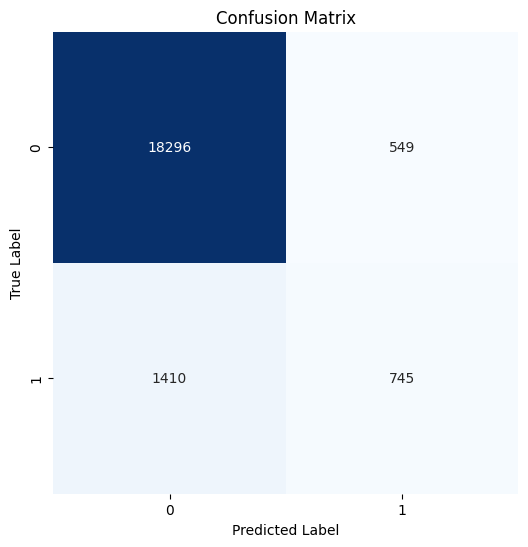

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     18845
           1       0.58      0.35      0.43      2155

    accuracy                           0.91     21000
   macro avg       0.75      0.66      0.69     21000
weighted avg       0.89      0.91      0.90     21000



In [213]:
# 
# Train an XGBoost classifier to see if this feature can explain churn
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model using 'latest_arpu_change' feature: {accuracy:.2f}")

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy of the model using 'latest_arpu_change' feature: 0.90
ROC AUC Score: 0.83


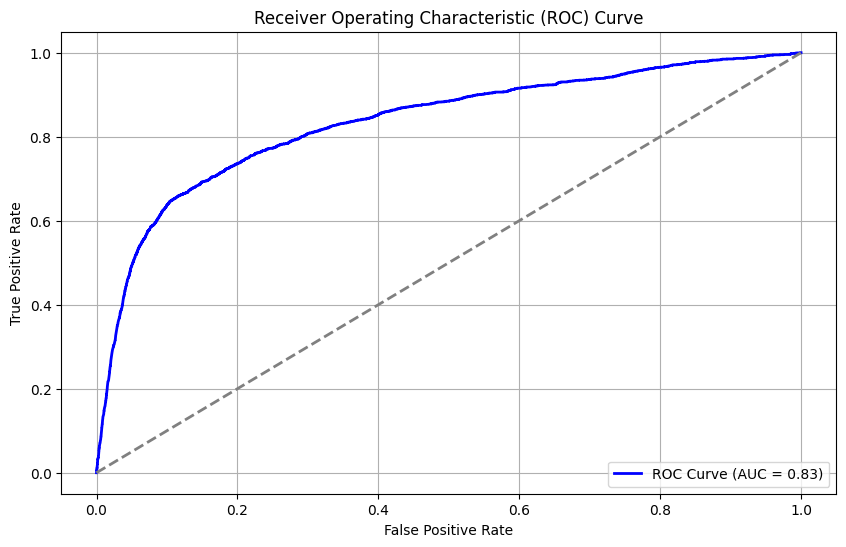

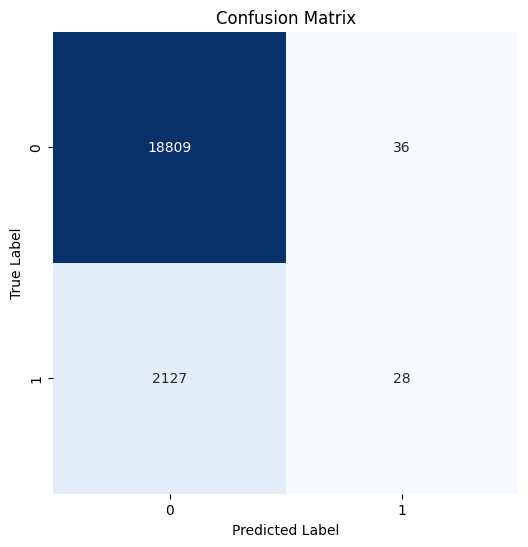

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     18845
           1       0.44      0.01      0.03      2155

    accuracy                           0.90     21000
   macro avg       0.67      0.51      0.49     21000
weighted avg       0.85      0.90      0.85     21000



In [214]:
# RandomForest

# Train a RandomForestClassifier to see if this feature can explain churn
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model using 'latest_arpu_change' feature: {accuracy:.2f}")

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=False))

Accuracy of the model using 'latest_arpu_change' feature: 0.90
ROC AUC Score: 0.63


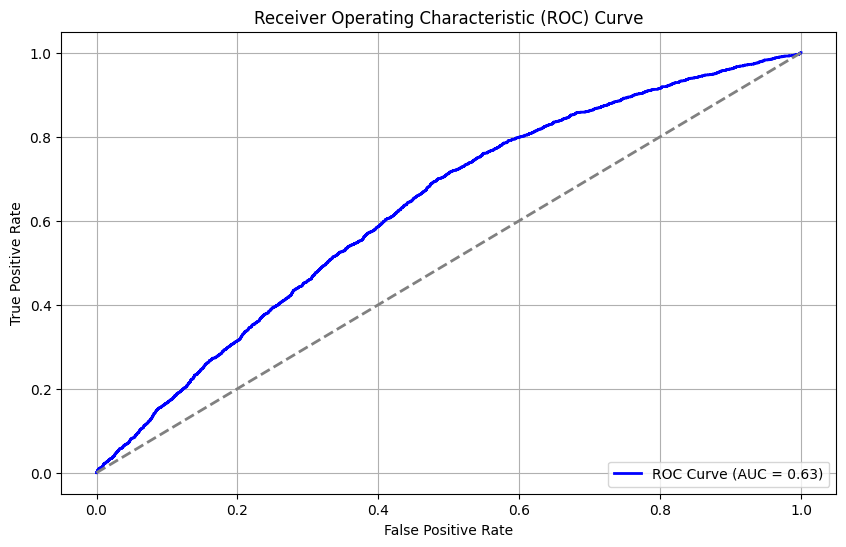

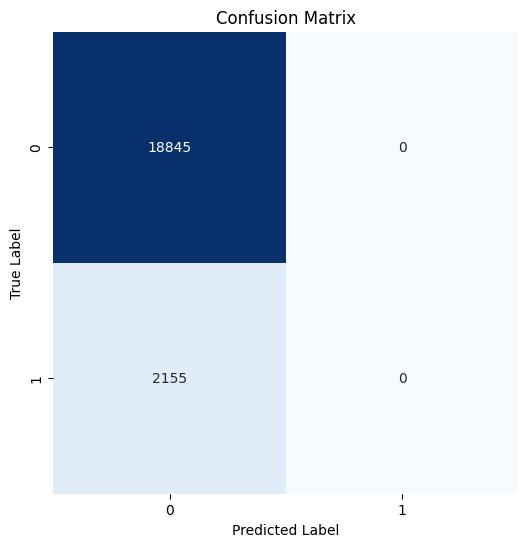

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     18845
           1       0.00      0.00      0.00      2155

    accuracy                           0.90     21000
   macro avg       0.45      0.50      0.47     21000
weighted avg       0.81      0.90      0.85     21000



In [223]:
# Naive Bayes

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Naive Bayes classifier to see if this feature can explain churn
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_model.predict(X_test)
y_pred_prob = nb_model.predict_proba(X_test)[:, 1]

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model using 'latest_arpu_change' feature: {accuracy:.2f}")

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=False))

In [222]:
# Make predictions on the test set with each model
nb_predictions = nb_model.predict(unseen_copy[features_in_use])
rf_predictions = rf_model.predict(unseen_copy[features_in_use])
xgb_predictions = xgb_model.predict(unseen_copy[features_in_use])

# Save the predictions to CSV files for Kaggle submission
submission_nb = pd.DataFrame({'id': unseen_copy['id'].astype(int), 'churn_probability': nb_predictions})
submission_rf = pd.DataFrame({'id': unseen_copy['id'].astype(int), 'churn_probability': rf_predictions})
submission_xgb = pd.DataFrame({'id': unseen_copy['id'].astype(int), 'churn_probability': xgb_predictions})

# Define filenames with the current date
current_date = datetime.datetime.now().strftime('%Y%m%d')
submission_nb_file_name = f"nb_churn_prediction_{current_date}.csv"
submission_rf_file_name = f"rf_churn_prediction_{current_date}.csv"
submission_xgb_file_name = f"xgb_churn_prediction_{current_date}.csv"

# Save to CSV
submission_nb.to_csv(submission_nb_file_name, index=False)
submission_rf.to_csv(submission_rf_file_name, index=False)
submission_xgb.to_csv(submission_xgb_file_name, index=False)

In [216]:
# # Define the pipeline steps
# pca_pipeline = Pipeline([
#     ('scaler', StandardScaler()),  # Step 1: Standardize the features
#     ('pca', PCA(n_components=0.99, random_state=42))   # Step 2: Apply PCA with specified number of components
# ])

# # Fit the pipeline on the data and transform it
# X_pca = pca_pipeline.fit_transform(X[numerical_cols])

# # Number of Components:
# num_of_components = pca_pipeline.named_steps['pca'].n_components_

# # Explained variance ratio for each principal component
# explained_variance = pca_pipeline.named_steps['pca'].explained_variance_ratio_
# print(f"Explained Variance Ratio for each Principal Component: \n{explained_variance}")

# # Optionally, create a DataFrame for the PCA results
# pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
# X_pca_df = pd.DataFrame(X_pca, columns=pca_columns)

# # Visualize cumulative explained variance
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o')
# plt.xlabel(f'Number of Principal Components (n={num_of_components})')
# plt.ylabel(f'Cumulative Explained Variance')
# plt.title('Explained Variance vs. Number of Components')
# plt.grid()
# plt.show()


In [217]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt


# # Select only numerical columns
# numerical_cols = X.select_dtypes(include=[np.number]).columns
# X_numeric = data[numerical_cols]

# # Define the pipeline steps with PCA based on explained variance threshold
# pca_pipeline = Pipeline([
#     ('scaler', StandardScaler()),           # Step 1: Standardize the features
#     ('pca', PCA(n_components=0.99))         # Step 2: Apply PCA to retain 99% variance
# ])

# # Fit the pipeline on the data and transform it
# pca_pipeline.fit(X_numeric)
# X_pca = pca_pipeline.transform(X_numeric)

# # Access the PCA step from the pipeline
# pca = pca_pipeline.named_steps['pca']

# # Get the components (loadings) of PCA (shape: [n_components, n_features])
# loadings = pca.components_

# # Create a DataFrame to display the loadings
# # Rows are components, columns are original features
# loadings_df = pd.DataFrame(loadings, columns=X_numeric.columns)

# # Determine the top contributing features to each principal component
# n_top_features = 5  # Adjust this to determine how many top features you want per component

# # Create a dictionary to store top contributing features for each principal component
# top_features_dict = {}
# for i in range(pca.n_components_):
#     component_loadings = loadings_df.iloc[i, :]  # Loadings for the i-th component
#     # Sort by absolute value to find the most contributing features
#     top_features = component_loadings.abs().sort_values(ascending=False).head(n_top_features).index.tolist()
#     top_features_dict[f'PC{i + 1}'] = top_features

# # Convert the dictionary to a DataFrame for better readability
# top_features_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in top_features_dict.items()]))

# # Display the top features contributing to each principal component
# # print(top_features_df)

# # Optionally, save the top features DataFrame to a CSV file
# top_features_df.to_csv('PCA_top_contributing_features.csv', index=False)  # Save results to CSV

# # Load the CSV file containing top contributing features
# top_features_df = pd.read_csv('PCA_top_contributing_features.csv')

# # Flatten the DataFrame to find the frequency of each feature across all components
# all_features = top_features_df.values.flatten()
# all_features = [feature for feature in all_features if pd.notna(feature)]  # Remove NaN values

# # Count the frequency of each feature
# feature_counts = pd.Series(all_features).value_counts()

# # Print features in the order of their importance
# print("Features in the order of their importance:")
# print(feature_counts)

# # Get the top 20 features based on frequency
# top_20_features = feature_counts.head(20).index.tolist()

# # Create a DataFrame with only the top 20 features
# top_20_features_df = data[top_20_features]

# # Include the target variable in the top 20 features
# top_20_features_df_with_target = data[top_20_features + ['churn_probability']]

# # Create a correlation matrix for the top 20 features including the target variable
# correlation_matrix = top_20_features_df_with_target.corr().round(2)

# # Plot a heatmap of the correlation matrix
# plt.figure(figsize=(14, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Heatmap for Top 20 Features')
# plt.show()

In [218]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming your dataset is loaded as 'data'
# # Separate features (X) from the target variable (y)
# # Select only numerical columns, excluding datetime columns
# numerical_cols = data.select_dtypes(include=[np.number]).columns
# X_numeric = data[numerical_cols]
# X = X_numeric

# y = data['churn_probability']

# # Initialize the RandomForestClassifier
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# # Fit the model on the data
# rf_model.fit(X, y)

# # Get feature importances from the RandomForest model
# feature_importances = rf_model.feature_importances_

# # Create a DataFrame to display features and their importance
# feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# # Sort the features by importance
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Print features in the order of their importance
# print("Features in the order of their importance:")
# print(feature_importance_df)

# # Write the feature importance DataFrame to a CSV file
# feature_importance_df.to_csv('feature_importance.csv', index=False)

# # Select the top 20 features for further analysis
# top_20_features = feature_importance_df.head(20)['Feature'].tolist()

# # Create a DataFrame with only the top 20 features and the target variable
# top_20_features_df = data[top_20_features + ['churn_probability']]

# # Create a correlation matrix for the top 20 features including the target variable
# correlation_matrix = top_20_features_df.corr().round(2)

# # Plot a heatmap of the correlation matrix
# plt.figure(figsize=(14, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Heatmap for Top 20 Features Including Churn Probability')
# plt.show()

# # # Alternative Plot: Boxplot to show impact of top features on churn
# # plt.figure(figsize=(14, 10))
# # for i, feature in enumerate(top_20_features[:6]):  # Plotting first 6 features for better visualization
# #     plt.subplot(2, 3, i + 1)
# #     sns.boxplot(x='churn_probability', y=feature, data=top_20_features_df)
# #     plt.title(f'Impact of {feature} on Churn')
# # plt.tight_layout()
# # plt.show()

In [219]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming your dataset is loaded as 'data'
# # Separate features (X) from the target variable (y)
# # Select only numerical columns, excluding datetime columns
# numerical_cols = data.select_dtypes(include=[np.number]).columns
# X_numeric = data[numerical_cols]
# X = X_numeric

# y = data['churn_probability']

# # Initialize the RandomForestClassifier
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# # Fit the model on the data
# rf_model.fit(X, y)

# # Get feature importances from the RandomForest model
# feature_importances = rf_model.feature_importances_

# # Create a DataFrame to display features and their importance
# feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# # Sort the features by importance
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Print features in the order of their importance
# print("Features in the order of their importance:")
# print(feature_importance_df)

# # Write the feature importance DataFrame to a CSV file
# feature_importance_df.to_csv('feature_importance.csv', index=False)

# # Select the top 20 features for further analysis
# top_20_features = feature_importance_df.head(20)['Feature'].tolist()

# # Create a DataFrame with only the top 20 features
# top_20_features_df = data[top_20_features]

# # Apply KMeans clustering to group similar features
# # Define the number of clusters (e.g., 5 clusters)
# n_clusters = 5
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# # Fit KMeans on the top 20 features
# kmeans.fit(top_20_features_df.T)

# # Get the cluster labels for each feature
# cluster_labels = kmeans.labels_

# # Create a DataFrame to display each feature and its assigned cluster
# cluster_df = pd.DataFrame({'Feature': top_20_features, 'Cluster': cluster_labels})

# # Print the clusters of features
# print("Clusters of features:")
# print(cluster_df)

# # Create a correlation matrix for the top 20 features including the target variable
# top_20_features_df_with_target = data[top_20_features + ['churn_probability']]
# correlation_matrix = top_20_features_df_with_target.corr().round(2)

# # Plot a heatmap of the correlation matrix
# plt.figure(figsize=(14, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Heatmap for Top 20 Features Including Churn Probability')
# plt.show()

# # Alternative Plot: Boxplot to show impact of top features on churn
# plt.figure(figsize=(14, 10))
# for i, feature in enumerate(top_20_features[:6]):  # Plotting first 6 features for better visualization
#     plt.subplot(2, 3, i + 1)
#     sns.boxplot(x='churn_probability', y=feature, data=top_20_features_df_with_target.reset_index())
#     plt.title(f'Impact of {feature} on Churn')
# plt.tight_layout()
# plt.show()